In [122]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.dates as mdates
import pyodbc

In [138]:
# Define connection string
conn_string = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=omnihub.database.windows.net;PORT=port_number;DATABASE=omnihub;UID=omnihubadmin;PWD=Administrator@123;'

# Establish a connection to the database
conn = pyodbc.connect(conn_string)
query="SELECT * FROM Omnihub.Fact_WaitingTime"
data = pd.read_sql(query,conn)

data = data.loc[data['CaseVolume'] != 0]
data = data.dropna()
data.head()

C:\Users\sanil\AppData\Local\Temp\ipykernel_12728\272745253.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query,conn)


,WaitingID,ProvinceTerritoryID,HealthRegionID,IndicatorID,Year,PercentMeetingBenchmark,FiftiethPercentileDay,NinetiethPercentileDay,CaseVolume
0,W00001,AB,AB0005,IND009,2014,70.0,99.0,280.0,188
1,W00002,AB,AB0001,IND009,2014,90.0,87.0,185.0,701
2,W00003,AB,AB0003,IND009,2014,88.0,95.0,191.0,704
3,W00004,AB,AB0004,IND009,2014,87.0,75.0,207.0,128
4,W00005,AB,AB0005,IND010,2014,64.0,127.0,308.0,340


In [139]:
data = data.dropna()
province_data = data[data['ProvinceTerritoryID'] == 'ON']
province_data['Year'] = pd.to_datetime(province_data['Year'], format='%Y')
province_data.set_index('Year', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 1167
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   WaitingID                964 non-null    object 
 1   ProvinceTerritoryID      964 non-null    object 
 2   HealthRegionID           964 non-null    object 
 3   IndicatorID              964 non-null    object 
 4   Year                     964 non-null    int64  
 5   PercentMeetingBenchmark  964 non-null    float64
 6   FiftiethPercentileDay    964 non-null    float64
 7   NinetiethPercentileDay   964 non-null    float64
 8   CaseVolume               964 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 75.3+ KB


C:\Users\sanil\AppData\Local\Temp\ipykernel_12728\2084670109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data['Year'] = pd.to_datetime(province_data['Year'], format='%Y')


In [154]:
#n_test = 12  # Example: Use the last 12 observations for testing
split_point = int(len(province_data['CaseVolume']) * 0.8)
train, test = province_data['CaseVolume'].iloc[:split_point], province_data['CaseVolume'].iloc[split_point:]


In [141]:
# Example ARIMA parameters
p, d, q = 1, 1, 1

model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [142]:
forecast = model_fit.get_forecast(steps=int(len(test)),exog=test)


C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [143]:
# Assuming 'forecast' is the result of a call to model.get_forecast or similar
forecasted_values = forecast.predicted_mean  # Extract predicted values

# Now you can calculate the MSE and RMSE
mse = mean_squared_error(test, forecasted_values)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

Test RMSE: 538.4407162518783


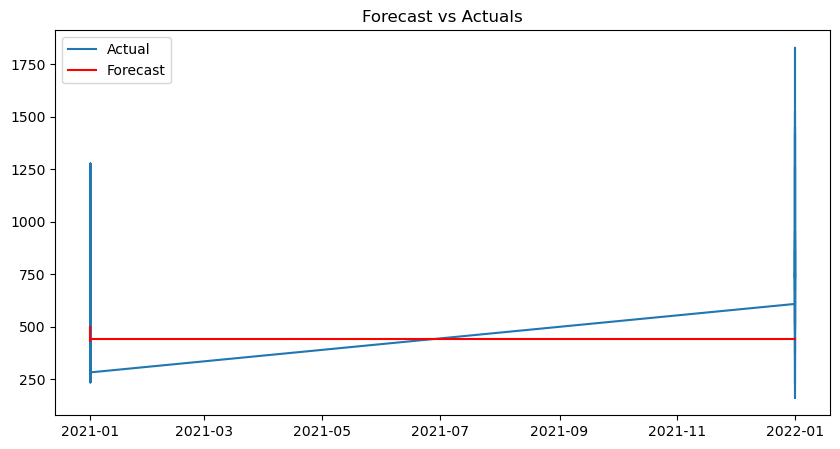

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecasted_values, label='Forecast', color='red')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()

In [156]:
# Example ARIMA parameters
p, d, q = 1, 1, 1

model = ARIMA(province_data['CaseVolume'], order=(p, d, q))
model_fit = model.fit()

C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [162]:
forecast_2023 = model_fit.forecast(steps=12)

C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [163]:
# Create a date range for 2023
forecast_index = pd.date_range(start='2023-01-01', periods=12, freq='M')

# Assign this date range as the index of the forecast_2023 series
forecast_2023.index = forecast_index

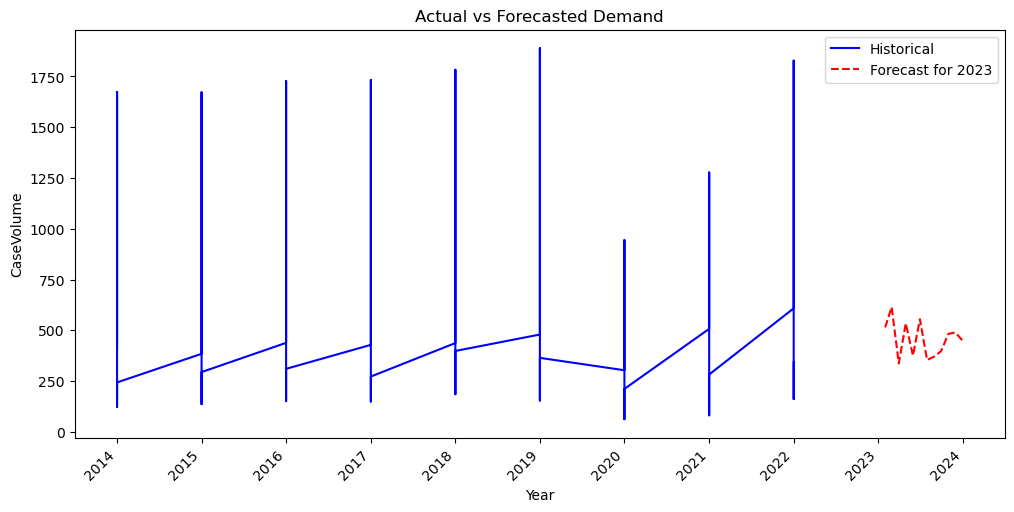

In [164]:
plt.figure(figsize=(12, 6))
# Plot the historical data
province_data['CaseVolume'].plot(label='Historical', color='blue')

# Plot the forecast with the adjusted index
forecast_2023.plot(label='Forecast for 2023', color='red', linestyle='--')

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optionally, rotate labels for better readability
plt.xticks(rotation=45)
plt.title('Actual vs Forecasted Demand')
plt.xlabel('Year')
plt.ylabel('CaseVolume')
plt.legend()
plt.show()

In [161]:
# Assuming yearly seasonality for monthly data, hence seasonal_periods=12
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add', damped_trend=True)
model_fit = model.fit(optimized=True)

C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [146]:
forecast = model_fit.forecast(steps=int(len(test)))

C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sanil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [147]:
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

Test RMSE: 543.1467039266809


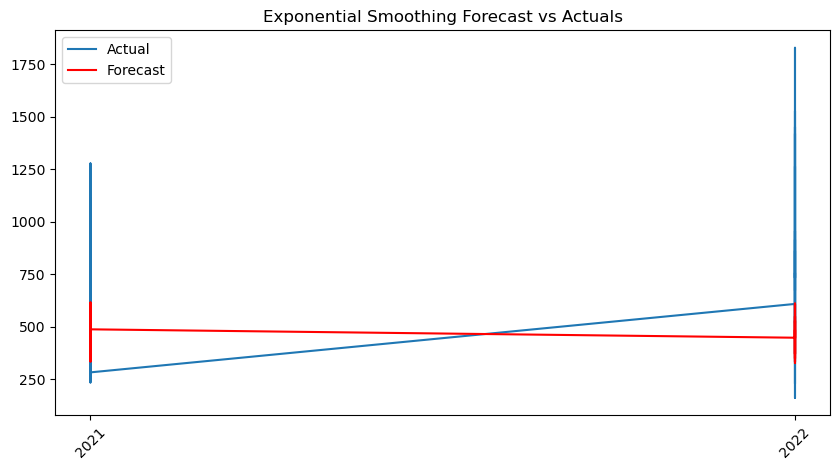

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optionally, rotate labels for better readability
plt.xticks(rotation=45)
plt.legend()
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()